# Find Something Important - Feature Importance

**Authors**: *@mrboneclinkz*

**Version**: *1.0*

**Description**: This function is used to find feature importance from supervised classification machine learning models. This function applying majority vote algorithm to determine best-N features, scored by sorting the highest to the lowest feature importance scores in each model, and then stack them into best-N features.

**Credits**

Titanic Data Set: https://www.kaggle.com/c/titanic/data

Feature Engineering: https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [1]:
#Standard libraries
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import time
#Preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## 1. Data Input

In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

C:\Users\mrbon\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

## 2. Determine X and Y variables

In [5]:
X = train.drop(["Survived"],axis=1)
y = train.Survived

In [6]:
col_name = X.columns
col_name

Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Name_length',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')

## 3. Split Training Testing

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.2,random_state=123)
print(f"X train: {X_train.shape[0]}, X test: {X_test.shape[0]}, y train: {y_train.shape[0]}, y test: {y_test.shape[0]} ")
print(f"Length of y_train: {len(y_train)}, while y_test: {len(y_test)}")
print(f"The comparison sum of category 0 and 1 from y_train: {np.bincount(y_train)}")
print(f"The comparison sum of category 0 and 1 from y_test: {np.bincount(y_test)}")

X train: 178, X test: 713, y train: 178, y test: 713 
Length of y_train: 178, while y_test: 713
The comparison sum of category 0 and 1 from y_train: [97 81]
The comparison sum of category 0 and 1 from y_test: [452 261]


C:\Users\mrbon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## 4. Define Model Space

In [8]:
#Modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xg
import catboost as cb
from prettytable import PrettyTable
from IPython.display import clear_output
#Ensemble Beberapa Classifier
clf_A = RandomForestClassifier()
clf_B = xg.XGBClassifier()
clf_C = lgb.LGBMClassifier(silent=True) #Ada irrelevant feature importance values, jadi di exclude
clf_D = cb.CatBoostClassifier(verbose=False)
clf_E = LogisticRegression()
clf_F = SVC()
clf_G = KNeighborsClassifier()
clf_H = BaggingClassifier()
clf_I = GradientBoostingClassifier()
clf_J = AdaBoostClassifier()
clf_total = [clf_A,clf_B,clf_C,clf_D,clf_E,clf_F,clf_G,clf_H,clf_I,clf_J]

## 5. Function Find Something Important

In [9]:
class FindSomethingImportant():
    """
    Function to find and create an ensemble feature importance score within one or more classifier models. 
    Suggestion, you may insert the optimized hyperparameter of each model to this function.
    
    Particularly, in this class, you can:
    1. Fit(X_train,y_train)
       Train all inserted models
    2. summarize()
       Give the feature importance information along with the overall best feature table
       
    Changelog:
    v1.0
    - First initialization
    - You should have prettytable, lightgbm, xgboost, and catboost installed in your notebook first
    - This function works well to all scikitlearn classifier, lightgbm, xgboost, and catboost
    - Not support for the automatic hyperparameter tuning
    - Not support for all deep learning models
    - Due to limited generalization, I used these abbrevations within my code. So, if you want to use it, please 
      set these libraries as what I named below:
        - Numpy as np
        - Pandas as pd
        - Catboost as cb
    - Require pretty table, seaborn, and matplotlib to be activated in the python environment
    
    """
    def __init__(self,random_state=123,limit=10,verbose=False,classifier=[RandomForestClassifier()],\
                show_plot = False, show_table = True):
        """
        Create the class, set the parameters.
        
        random_state = Set your seed [Default = 123]
        limit = Set your maximum features shown in the feature importance [Default = 10]
        verbose = Show the track information along the process [Default = False]
        classifier = Use only the classifier, otherwise automatically set to RandomForestClassifier. You can add
                     some models in a list. [Default = RandomForestClassifier()]
        show_plot = Show the plot on the summarize result [Default = False]
        show_table = Show the importance table on the summarize result [Default = True]
        
        Restrictions:
        
        
        """

        self.verbose = verbose
        self.random_state = random_state
        self.show_plot = show_plot
        self.show_table = show_table
        self.__train_table = False
        self.importance = {}
        self.__fi_score = {}
        self.__importance_sign = {}
        if limit > len(col_name):
            limit = len(col_name)
        if limit < 0 or limit >100:
            print("Limit is limited between 1 - 100. Automatically set to 10")
            self.limit = 10
        else:
            self.limit = limit
        try:
            cache_logic = len(classifier)
            clf_list = []
            for i in range(len(classifier)):
                if "Classifier" not in str(classifier[i].__class__):
                    print(f"{classifier[i]} is not classifier class, automatically remove from the list.")
                else:
                    clf_list.append(classifier[i])
            if len(clf_list) == 0:
                print("Since there is no eligible classifier, automatically set to Random Forest Classifier")
                self.classifier = [RandomForestClassifier(random_state=self.random_state)]
            else:
                self.classifier = clf_list
        except:
            if "Classifier" not in str(classifier.__class__):
                print(f"{classifier.__class__.__name__} is not classifier class, automatically set to Random Forest Classifier")
                self.classifier = [RandomForestClassifier(random_state=self.random_state)]
            else:
                self.classifier = [classifier]
        self.__classifier_name_list= []
        for i in range(len(self.classifier)):
            self.__classifier_name_list.append(self.classifier[i].__class__.__name__)
        print("=================================================================")
        print("Show Importance Function v1.0")
        print(f"Trying to find feature importances from {self.__classifier_name_list}")
        print("=================================================================")
        
    def __importance_table_func(self,classifier_at):
        """
        
        Create the table of feature importance, sort descently
        
        """
        class_name = classifier_at.__class__.__name__
        index = np.argsort(self.importance[class_name])
        t = PrettyTable(["Category name","Feature Importances","Score"])
        for i in range(self.limit):
            t.add_row([self.__colnames[index][len(self.importance[class_name])-self.limit:][self.limit-i-1],
                      self.importance[class_name][index][len(self.importance[class_name])-self.limit:][self.limit-i-1],
                      self.limit-i])
        print(t)
        return t
    
    def fit(self,X,y,colnames):
        """
        Train the models you've input in this class. 
        
        X = Your X_train
        y = Your y_train
        colnames = The feature names in a list. Column names. If it is empty, the feature names will be set to a
                 sequence of number from 1 to N (maximum length of your feature)
        
        """
        try:
            cache_test = len(colnames)
            self.__colnames = np.array(colnames)
        except:
            print("Column name is empty, automatically set to sequence number from 1 to N")
            self.__colnames = np.array([x+1 for x in range(np.array(X).shape[1])])
        self.X = (X if isinstance(X,np.ndarray) else np.array(X))
        self.y = (y if isinstance(y,np.ndarray) else np.array(y))
        
        if self.__train_table == False:
            start_time_all = time.time()
            for i in range(len(self.classifier)):
                class_name = self.classifier[i].__class__.__name__
                if self.verbose:
                    print(f"Training Process on {class_name}")
                start_time = time.time()
                self.classifier[i].fit(self.X,self.y)
                elapsed_time = time.time() - start_time
                if self.verbose:
                    print("=================================================================")
                    print(f"Training Complete")
                    print(f"Elapsed: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")
                    print("=================================================================")
                try:  
                    try:
                        self.importance[class_name] = self.classifier[i].feature_importances_
                    except:
                        self.importance[class_name] = np.array(self.classifier[i].get_feature_importance(\
                                                                                 cb.Pool(self.X,label=self.y)))
                    calc_index = np.argsort(self.importance[class_name])
                    calc_fi_score = 0
                    col_name_loop = []
                    for j in range(self.limit):
                        calc_fi_score += self.importance[class_name][calc_index][len(self.importance[class_name]\
                                                                                 )-self.limit:][self.limit-j-1]
                        col_name_loop.append(self.__colnames[calc_index][len(self.importance[class_name])-self.limit:][\
                                      self.limit-j-1])
                    self.__importance_sign[class_name] = col_name_loop
                    self.__fi_score[class_name] = calc_fi_score
                except AttributeError:
                    print(f"{class_name} has no attribute Feature Importance. Stored nothing.")
                    self.importance[class_name] = np.array([0 for x in range(len(col_name))])
                    self.__importance_sign[class_name] = col_name
                    self.__fi_score[class_name] = 0
                
            clear_output()
            elapsed_time_all = time.time() - start_time_all
            print("=================================================================")
            print(f"Training All Classifiers Completed")
            print(f"Elapsed: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time_all))}")
            print("=================================================================")
            self.__train_table = True
        else:
            print("Data have already been trained. Try summarize()")

    def summarize(self):
        """
        
        Summarize the feature importance by table and or bar chart. Also, return a data frame, as a
        result from majority voting of feature importance from all classifiers.
        
        """
        all_class = []
        for i in range(len(self.classifier)):
            class_name = self.classifier[i].__class__.__name__
            calc_index = np.argsort(self.importance[class_name])
            all_class.append(self.__importance_sign[class_name])
            if self.show_table:
                print(f"Top {self.limit} of {class_name} Feature Importances:")
                self.__importance_table_func(self.classifier[i])          
            print(f"FI Cummulative Score of {class_name}: {self.__fi_score[class_name]}")
            print("")
        top_features = {}
        for i in all_class:
            for index,value in enumerate(i):
                score = (len(i)-index)
                if value not in top_features:
                    top_features[value] = 1*score
                else:
                    top_features[value] += score
        total_feature_include = self.limit*len(self.classifier)
        best_features = sorted(top_features.items(), key=lambda x: x[1],reverse=True)
        self.most_important_features = pd.DataFrame(best_features[:self.limit])
        self.most_important_features.columns = ["Feature","Score"]
        self.most_important_features["Percentage"] = self.most_important_features["Score"].map(lambda x: 100*round(x/total_feature_include,2))
        if self.show_plot:
            self.most_important_features.set_index("Feature")["Percentage"].plot(kind="bar",figsize=(14,7),\
            title="Top Feature Overall")
        return self.most_important_features

## 6. Implement

In [10]:
%%time
find_importance_all = FindSomethingImportant(random_state=123,limit=11,verbose=True,\
                             classifier=clf_total,\
                             show_plot = True, show_table = False)
find_importance_all.fit(X_train,y_train,col_name)

Training All Classifiers Completed
Elapsed: 00:00:32
Wall time: 32.6 s


FI Cummulative Score of RandomForestClassifier: 1.0

FI Cummulative Score of XGBClassifier: 0.9999999906867743

FI Cummulative Score of LGBMClassifier: 570

FI Cummulative Score of CatBoostClassifier: 100.0

FI Cummulative Score of KNeighborsClassifier: 0

FI Cummulative Score of BaggingClassifier: 0

FI Cummulative Score of GradientBoostingClassifier: 1.0

FI Cummulative Score of AdaBoostClassifier: 1.0



,Feature,Score,Percentage
0,Name_length,71,81.0
1,Pclass,64,73.0
2,Age,60,68.0
3,Title,59,67.0
4,Fare,56,64.0
5,FamilySize,51,58.0
6,Sex,46,52.0
7,Has_Cabin,39,44.0
8,Embarked,36,41.0
9,Parch,32,36.0


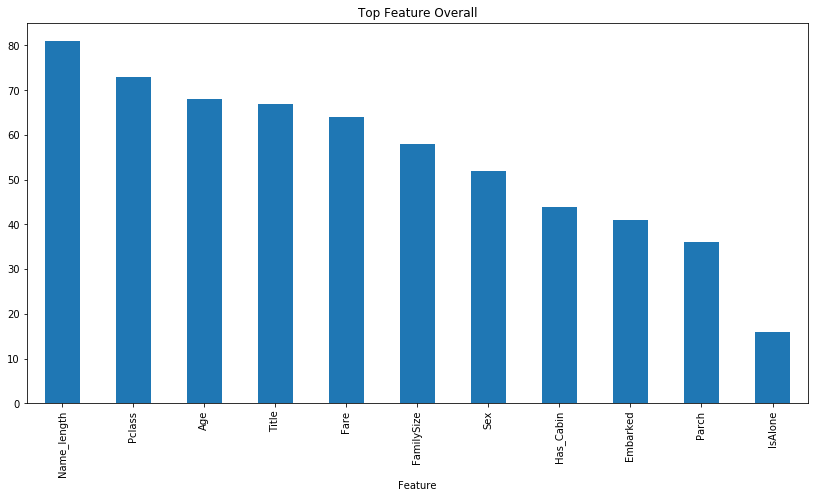

In [11]:
find_importance_all.summarize()